In [75]:
import shap
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics.pairwise import haversine_distances
from math import radians

### Load Dataset

In [7]:
quad_data = pd.read_csv("datasets/QuadCopter/QuadData.csv")
print(quad_data.shape)
quad_data.head()

(8791, 93)


,id,ExpID,PatternID,DeviceID,LineNo_ATT,TimeUS_ATT,DesRoll,Roll,DesPitch,Pitch,...,MOfsY_2,MOfsZ_2,LineNo_RCOU,TimeUS_RCOU,C1,C2,C3,C4,Lat,Lng
0,0,6,2,F450,14206,867051417,-2.52,-0.74,-2.30,-1.55,...,0,0,14207,867051676,1536,1578,1719,1726,-6.557158,106.733964
1,1,6,2,F450,14216,867251550,-2.64,0.28,-2.95,-1.02,...,0,0,14217,867251950,1581,1553,1697,1733,-6.557158,106.733964
2,2,6,2,F450,14226,867451412,-2.80,-0.42,-3.46,-1.85,...,0,0,14227,867451674,1601,1540,1690,1726,-6.557159,106.733964
3,3,6,2,F450,14236,867651882,-2.63,-1.31,-3.70,-3.97,...,0,0,14237,867652298,1604,1529,1712,1683,-6.557159,106.733964
4,4,6,2,F450,14246,867851500,-2.38,-0.74,-2.95,-4.04,...,0,0,14247,867851877,1594,1520,1682,1693,-6.557159,106.733964


In [8]:
quad_data = quad_data[~quad_data['Lat'].isnull()].reset_index(drop=True)
quad_data.shape

(6440, 93)

### Exploratory Data Analysis

In [9]:
# See: 
# - how many experiments done in this data (ExpID)
# - how many routes existed (PatternID)
# - how many quadcopter used (DeviceID)

quad_data.groupby(["ExpID", "PatternID", "DeviceID"]).size()

ExpID  PatternID  DeviceID
1      1          F450        285
2      1          F450        702
3      1          F450        604
4      1          F450        652
5      1          F450        621
6      2          F450        516
7      1          F330        236
8      2          F330        729
9      2          F330        419
10     2          F330        728
11     2          F330        517
12     2          F330        431
dtype: int64

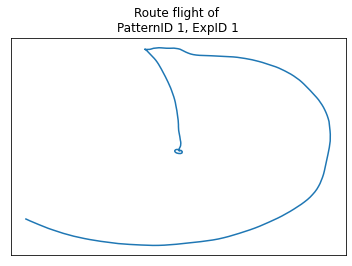

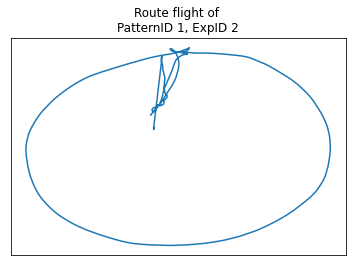

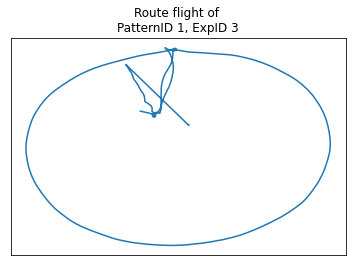

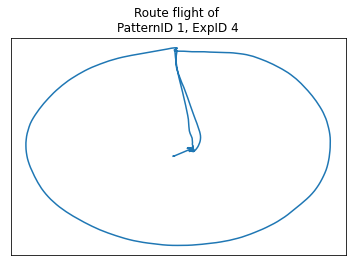

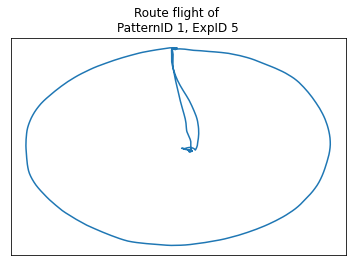

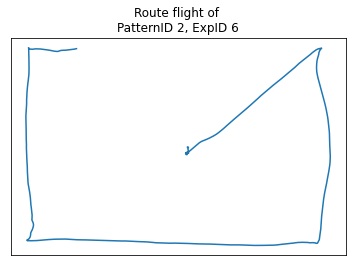

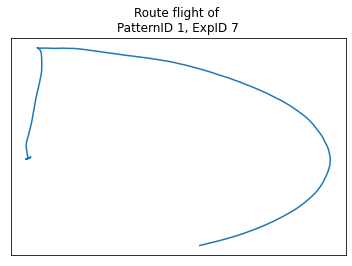

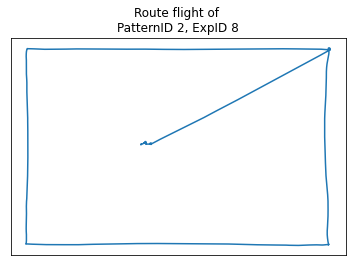

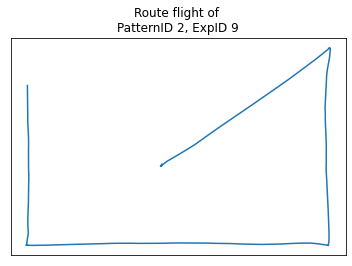

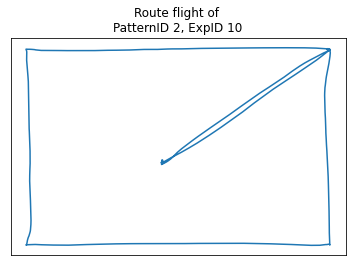

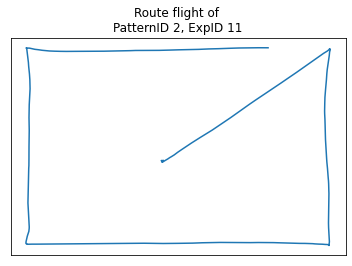

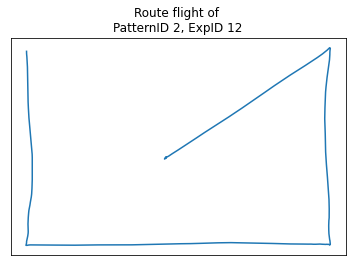

In [10]:
# Plot all the flights
for i in range(1, 13):
    plt.subplots()
    
    plt.plot(quad_data[quad_data["ExpID"] == i]['Lat'], quad_data[quad_data["ExpID"] == i]['Lng'])
    plt.xticks([], [])
    plt.yticks([], [])
    
    pattern_id = quad_data[quad_data["ExpID"] == i]["PatternID"].unique()[0]

    plt.title("Route flight of \nPatternID %s, ExpID %s" % (pattern_id, i))
    plt.show()

In [11]:
len(quad_data[quad_data['ExpID'] == 1])

285

In [12]:
# Minimum and maximum latitude
quad_data['Lat'].min(), quad_data['Lat'].max() 

(-6.5574588, -6.556893400000001)

In [13]:
# Minimum and maximum longitude
quad_data['Lng'].min(), quad_data['Lng'].max() 

(106.7336888, 106.734247)

### Feature Engineering 

#### 1. Lat-Lng - Standard Scaler

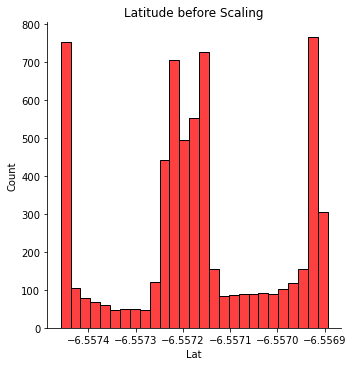

In [14]:
sns.displot(quad_data['Lat'], color='r')
plt.title("Latitude before Scaling")

plt.show()

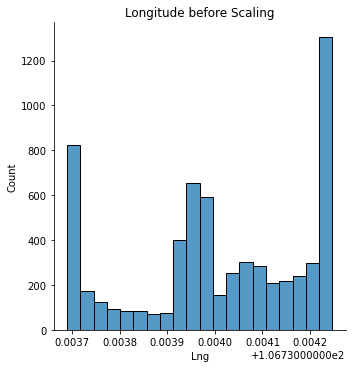

In [15]:
sns.displot(quad_data['Lng'])
plt.title("Longitude before Scaling")

plt.show()

In [16]:
# Create standard distriubtion scaler for longitude
sc_long = StandardScaler()
new_long = sc_long.fit_transform(quad_data[['Lng']])
quad_data['Lng_Scaled'] = new_long

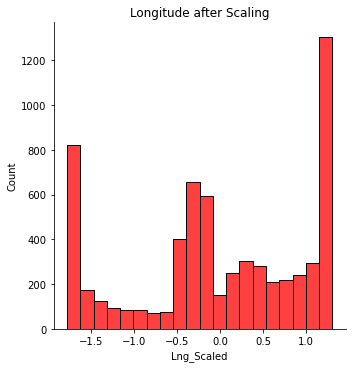

In [17]:
sns.displot(quad_data['Lng_Scaled'], color='r')
plt.title("Longitude after Scaling")
plt.show()

In [18]:
# Create standard distriubtion scaler for latitude
sc_lat = StandardScaler()
new_lat = sc_lat.fit_transform(quad_data[['Lat']])
quad_data['Lat_Scaled'] = new_lat

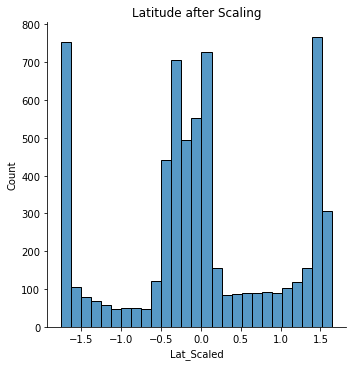

In [19]:
sns.displot(quad_data['Lat_Scaled'])
plt.title("Latitude after Scaling")
plt.show()

#### 2. PatternID & DeviceID - Create Dummy Variables

In [20]:
quad_data[['PatternID', 'DeviceID']].head()

,PatternID,DeviceID
0,2,F450
1,2,F450
2,2,F450
3,2,F450
4,2,F450


In [21]:
pd.get_dummies(quad_data["PatternID"], prefix="PatternID").head()

,PatternID_1,PatternID_2
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [22]:
pd.get_dummies(quad_data["DeviceID"], prefix="DeviceID").head()

,DeviceID_F330,DeviceID_F450
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [23]:
# Concat with the original dataframe
print(quad_data.shape)
quad_data = pd.concat([quad_data, pd.get_dummies(quad_data["PatternID"], prefix="PatternID")], axis=1)
quad_data = pd.concat([quad_data, pd.get_dummies(quad_data["DeviceID"], prefix="DeviceID")], axis=1)
quad_data = quad_data.drop("DeviceID", axis=1)
quad_data.shape

(6440, 95)


(6440, 98)

#### 3. Yaw - Degree to Cardinal Direction

In [24]:
quad_data['Yaw'].head()

0      2.12
1    359.69
2    357.66
3    356.25
4    355.72
Name: Yaw, dtype: float64

In [25]:
def deg_to_compass(num):
    val = int((num/22.5)+.5)
    arr = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    return arr[(val % 16)]

In [26]:
quad_data['Yaw_Dir'] = quad_data['Yaw'].apply(lambda x: deg_to_compass(x)).astype("category")
quad_data['Yaw_Dir'].head()

0    N
1    N
2    N
3    N
4    N
Name: Yaw_Dir, dtype: category
Categories (16, object): ['E', 'ENE', 'ESE', 'N', ..., 'SW', 'W', 'WNW', 'WSW']

In [27]:
le_yaw = LabelEncoder()
quad_data['Yaw_Dir'] = le_yaw.fit_transform(quad_data['Yaw_Dir'])
quad_data['Yaw_Dir'].head()

0    3
1    3
2    3
3    3
4    3
Name: Yaw_Dir, dtype: int64

#### 4. Yaw - Degree to Radians

In [28]:
quad_data['Yaw'].head()

0      2.12
1    359.69
2    357.66
3    356.25
4    355.72
Name: Yaw, dtype: float64

In [29]:
def deg_to_radian(degree):
    return degree * (np.pi/180)

In [30]:
quad_data['Yaw_Rad'] = quad_data['Yaw'].apply(lambda x: deg_to_radian(x))
quad_data['Yaw_Rad'].head()

0    0.037001
1    6.277775
2    6.242345
3    6.217735
4    6.208485
Name: Yaw_Rad, dtype: float64

#### 5. Magnitude - Total All Axis Magnitude

In [31]:
quad_data["Mag_Total"] =  quad_data["MagX"] + quad_data["MagY"] + quad_data["MagZ"]
quad_data["Mag_Total"].head()

0    170
1    196
2    203
3    193
4    196
Name: Mag_Total, dtype: int64

### Feature Selection

In [32]:
quad_data.shape

(6440, 101)

In [33]:
# Create correlation matrix
corr = quad_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if np.any(np.where((upper[column] > 0.95) & (upper[column] < 0.99)))]
to_drop.append("id")
to_drop

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['ThO',
 'Alt',
 'BAlt',
 'HDop',
 'AccX_2',
 'OfsZ',
 'MagX_2',
 'MagY_2',
 'OfsX_2',
 'OfsY_2',
 'DeviceID_F330',
 'DeviceID_F450',
 'id']

In [34]:
quad_data = quad_data.drop(to_drop, axis=1)
quad_data.shape

(6440, 88)

### Training

In [35]:
# Split data stratified based on pattern
# We have 12 experiments:
# -> 6 PatternID: 1
# -> 6 PatternID: 2

quad_data.groupby(["ExpID", "PatternID"]).size()

ExpID  PatternID
1      1            285
2      1            702
3      1            604
4      1            652
5      1            621
6      2            516
7      1            236
8      2            729
9      2            419
10     2            728
11     2            517
12     2            431
dtype: int64

In [36]:
# Split data stratified by PatternID:
# Train: 2/3 (8)
# Test: 1/3 (4)
train_exp_id = [1, 3, 5, 7, 6, 8, 10, 12]
test_exp_id = [2, 4, 9, 11]

train_data = quad_data[quad_data['ExpID'].isin(train_exp_id)].drop(["Lat", "Lng", "PatternID"], axis=1)
test_data = quad_data[quad_data['ExpID'].isin(test_exp_id)].drop(["Lat", "Lng", "PatternID"], axis=1)

print(train_data.shape)
print(test_data.shape)

(4150, 85)
(2290, 85)


In [37]:
X_train, y_train_lat, y_train_lng = train_data.drop(["Lat_Scaled", "Lng_Scaled"], axis=1), train_data["Lat_Scaled"], train_data["Lng_Scaled"]
X_test, y_test_lat, y_test_lng = test_data.drop(["Lat_Scaled", "Lng_Scaled"], axis=1), test_data["Lat_Scaled"], test_data["Lng_Scaled"]

In [38]:
# Train on latitude
xgb_lat = XGBRegressor()
xgb_lat.fit(X_train, y_train_lat, verbose=5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [78]:
# Using tuned latitude model
xgb_lat = pickle.load(open("xgb_tuned_lat.pickle", "rb"))

In [39]:
# Train on longitude
xgb_lng = XGBRegressor()
xgb_lng.fit(X_train, y_train_lng, verbose=5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [79]:
# Using tuned longitude model
xgb_lng = pickle.load(open("xgb_tuned_lng.pickle", "rb"))

### Evaluate Haversine Distance

In [80]:
# Predict lat & long for test data, per experiment
pred_lat = X_test.groupby("ExpID").apply(lambda x: sc_lat.inverse_transform(xgb_lat.predict(x).reshape(-1,1)).reshape(-1))
pred_lng = X_test.groupby("ExpID").apply(lambda x: sc_long.inverse_transform(xgb_lng.predict(x).reshape(-1,1)).reshape(-1))

In [81]:
pred_lat.index

Int64Index([2, 4, 9, 11], dtype='int64', name='ExpID')

In [82]:
pred_lat_flatten = np.array([])
for exp_pred in pred_lat:
    pred_lat_flatten = np.concatenate((pred_lat_flatten, exp_pred))
    
pred_lng_flatten = np.array([])
for exp_pred in pred_lng:
    pred_lng_flatten = np.concatenate((pred_lng_flatten, exp_pred))

In [83]:
pred_lat_flatten.shape, pred_lng_flatten.shape

((2290,), (2290,))

In [84]:
pred_coordinates = list(zip(pred_lat_flatten, pred_lng_flatten))
pred_coordinates[:5]

[(-6.557118892669678, 106.73402404785156),
 (-6.557116508483887, 106.73402404785156),
 (-6.557119846343994, 106.73401641845703),
 (-6.557118892669678, 106.73401641845703),
 (-6.5571160316467285, 106.73401641845703)]

In [85]:
# Actual coordinates
actual_coordinates = list(zip(sc_lat.inverse_transform(y_test_lat.values.reshape(-1,1)).reshape(-1), sc_long.inverse_transform(y_test_lng.values.reshape(-1,1)).reshape(-1)))
actual_coordinates[:5]

[(-6.5572132, 106.7339226),
 (-6.5572133, 106.7339225),
 (-6.557213099999999, 106.7339224),
 (-6.557213000000001, 106.7339222),
 (-6.557212799999999, 106.7339222)]

In [86]:
def evaluate_haversine(coord1, coord2):
    coord1_radians = [radians(_) for _ in coord1]
    coord2_radians = [radians(_) for _ in coord2]

    result = haversine_distances([coord1_radians, coord2_radians]) * 6371

    return result[0][1]

In [87]:
distances_pattern1 = []
distances_pattern2 = []

count = 1
for i in range(pred_lng_flatten.shape[0]):
    if count <= pred_lat[2].shape[0] + pred_lat[4].shape[0]:
        distances_pattern1.append(evaluate_haversine(pred_coordinates[i], actual_coordinates[i]))
    else:
        distances_pattern2.append(evaluate_haversine(pred_coordinates[i], actual_coordinates[i]))
        
    count +=1

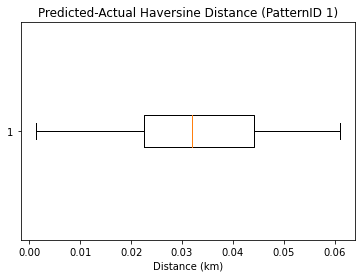

Mean haversine distance: 0.032847670710050146 km


In [88]:
plt.boxplot(distances_pattern1, vert=False)
plt.title("Predicted-Actual Haversine Distance (PatternID 1)")
plt.xlabel("Distance (km)")
plt.show()
print("Mean haversine distance: %s km" % np.mean(distances_pattern1))

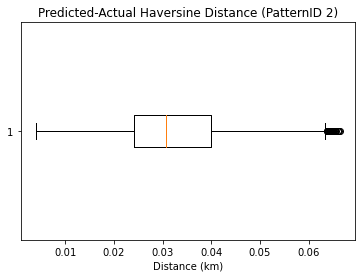

Mean haversine distance: 0.03305111726797992 km


In [89]:
plt.boxplot(distances_pattern2, vert=False)
plt.title("Predicted-Actual Haversine Distance (PatternID 2)")
plt.xlabel("Distance (km)")
plt.show()
print("Mean haversine distance: %s km" % np.mean(distances_pattern2))

### Qualitative Evaluation

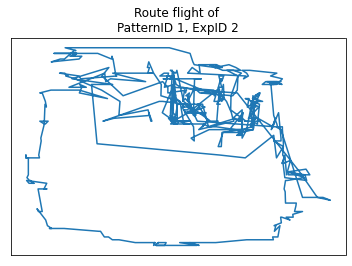

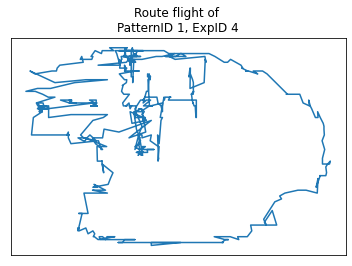

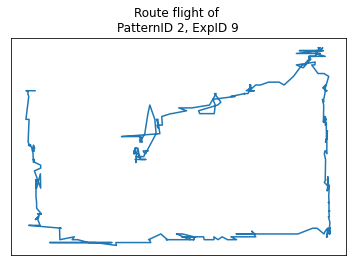

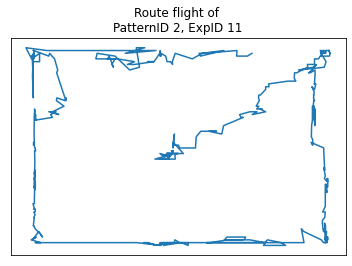

In [90]:
# Plot flight prediction
for exp_id in pred_lat.index:
    plt.subplots()
    
    plt.plot(pred_lat[exp_id], pred_lng[exp_id])
    plt.xticks([], [])
    plt.yticks([], [])
    
    pattern_id = quad_data[quad_data["ExpID"] == exp_id]["PatternID"].unique()[0]

    plt.title("Route flight of \nPatternID %s, ExpID %s" % (pattern_id, exp_id))
    plt.show()

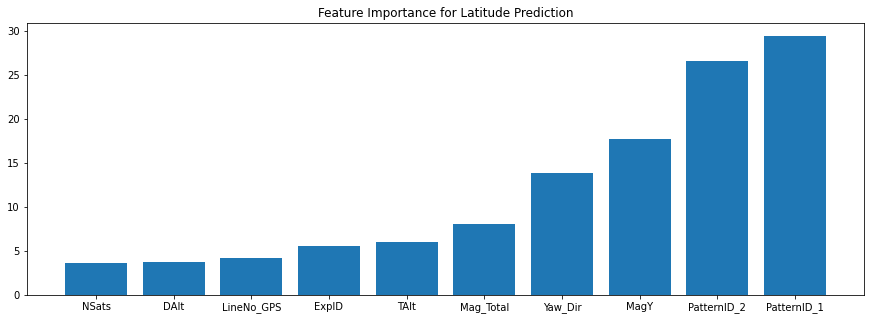

In [91]:
imp_dict = dict(sorted(xgb_lat.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1]))
feat_names = list(imp_dict.keys())
importances = list(imp_dict.values())

plt.figure(figsize=(15,5))
plt.bar(x=feat_names[-10:], height=importances[-10:])
plt.title("Feature Importance for Latitude Prediction")
plt.show()

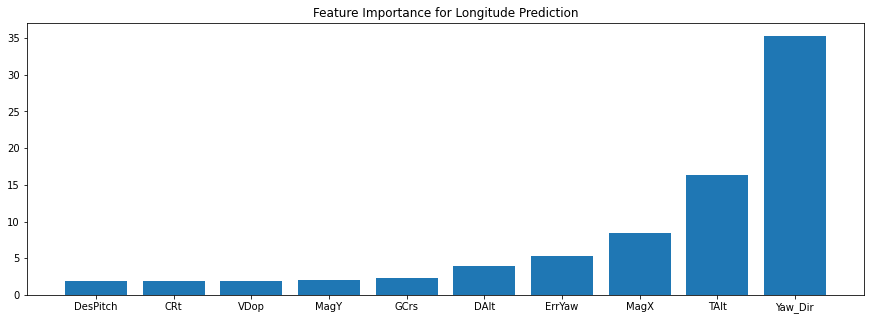

In [92]:
imp_dict = dict(sorted(xgb_lng.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1]))
feat_names = list(imp_dict.keys())
importances = list(imp_dict.values())

plt.figure(figsize=(15,5))
plt.bar(x=feat_names[-10:], height=importances[-10:])
plt.title("Feature Importance for Longitude Prediction")
plt.show()

### Hyperparameter Tuning

In [69]:
xgb_tuned_lat = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.01, .03, .05, .07, .1],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [.7,.8,.9],
              'colsample_bytree': [.7,.8, .9],
              'n_estimators': [500]}

xgb_grid_lat = RandomizedSearchCV(xgb_tuned_lat, parameters, cv=5, n_jobs=-1, verbose=5)
xgb_grid_lat.fit(X_train, y_train_lat)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:36:25] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:36:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [70]:
print(xgb_grid_lat.best_params_)
print(xgb_grid_lat.best_score_)

{'subsample': 0.9, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.07, 'colsample_bytree': 0.7}
0.47830333298696665


In [76]:
pickle.dump(xgb_grid_lat.best_estimator_, open("xgb_tuned_lat.pickle", "wb"))

In [71]:
xgb_tuned_lng = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.01, .03, .05, .07, .1],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [.7,.8,.9],
              'colsample_bytree': [.7,.8, .9],
              'n_estimators': [500]}

xgb_grid_lng = RandomizedSearchCV(xgb_tuned_lng, parameters, cv=5, n_jobs=-1, verbose=5)
xgb_grid_lng.fit(X_train, y_train_lng)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:39:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [72]:
print(xgb_grid_lng.best_params_)
print(xgb_grid_lng.best_score_)

{'subsample': 0.9, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.07, 'colsample_bytree': 0.9}
0.7378125855336737
[00:32:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=500, objective=reg:linear, silent=1, subsample=0.8;, score=0.524 total time= 1.8min
[00:34:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:42] WARNING: ../src/learner

In [77]:
pickle.dump(xgb_grid_lng.best_estimator_, open("xgb_tuned_lng.pickle", "wb"))